# Student Name: Xavier Geoffrey Niroopen
# Student Id: 23263806

- For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.
- You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
- For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
- Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
- Summarise your experience in a markdown cell (max 150 words in a markdown cell).

In [99]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif

# from sklearn import svm
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [53]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [54]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

First of all let's check for missing values and outliers.

In [55]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [56]:
df.loc[:,'insurance_cost'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: insurance_cost, dtype: float64

<Axes: >

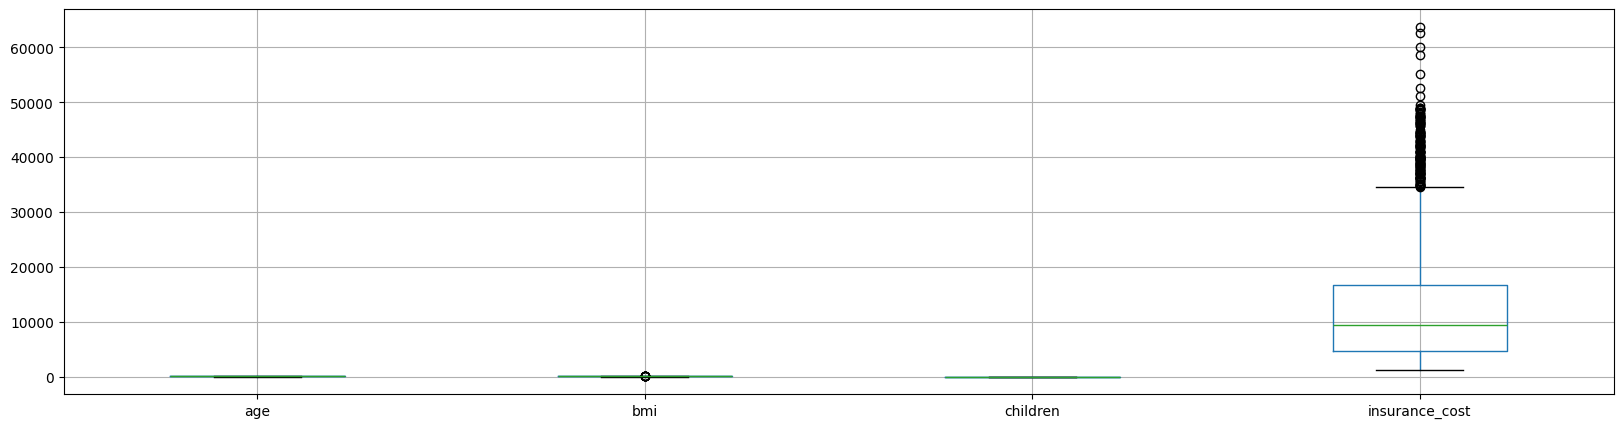

In [57]:
num_cols = df.select_dtypes(include=['int', 'float']).columns
df.loc[:,num_cols].boxplot(figsize=(20,5))

Let's also examine the histograms of all attribtes.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'insurance_cost'}>]], dtype=object)

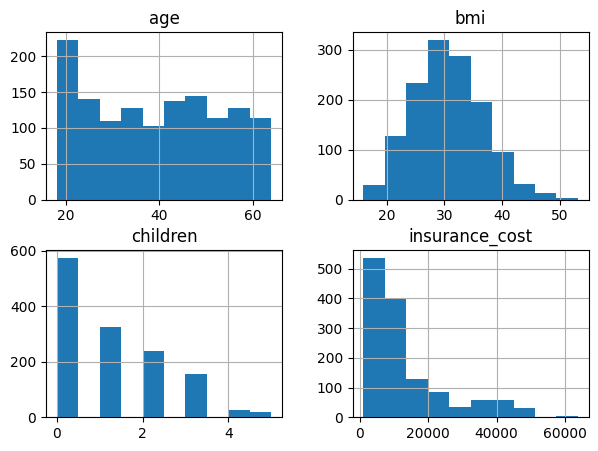

In [58]:
df.hist(bins=10, figsize=(7, 5))

- Robust Scaler: similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.
- Robust Scaler: doesn't take the median into account and only focuses on the parts where the bulk data is.
- Standardization: scales features such that the distribution is centered around 0, with a standard deviation of 1.
- Standardization: not good if the data is not normally distributed (i.e. no Gaussian Distribution).

- For `bmi`, have outliers. I will apply `RobustScaler` to it and cube transform it.
- For `age`, I will apply `StandardScaler` 
- For `children`, I will apply `StandardScaler`


## Data Preparation

Replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise.

In [59]:
median_insurance_cost = df['insurance_cost'].median()
print(f"Median cost of insurance: {median_insurance_cost}")

df['insurance_cost_binary'] = (df['insurance_cost'] > median_insurance_cost).astype(int)
df = df.drop(columns=['insurance_cost'])


Median cost of insurance: 9382.033


In [60]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

In [61]:
unique_regions = df['region'].unique()
unique_regions

array(['southeast', 'northeast', 'southwest', 'northwest'], dtype=object)

In [62]:
unique_smoker = df['smoker'].unique()
unique_smoker

array(['no', 'yes'], dtype=object)

In [63]:
unique_gender = df['gender'].unique()
unique_gender

array(['male', 'female'], dtype=object)

In [64]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

Index(['gender', 'smoker', 'region'], dtype='object')

In [65]:
num_cols = df.select_dtypes(exclude=['object']).columns
num_cols

Index(['age', 'bmi', 'children', 'insurance_cost_binary'], dtype='object')

Next we split the columns into a target *`y`* and predictors *`X`*.

In [66]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

Here we prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we apply later. The use of this pipeline ensures that preprocessing is applied separately to each training, validation, and test dataset, preventing data leakage.

First, we partition the `predictors` into three groups, to which we apply different data preparation.

In [67]:
age = ['age']
bmi = ['bmi']
children = ['children']

In [68]:
onehotencode_cols = ['gender', 'smoker', 'region']

Then we can build the preprocessing pipeline by using Pipeline and ColumnTransformer as follows.

In [69]:
onehotencode_pipeline = Pipeline(
    steps = [
        ('onehot', OneHotEncoder(drop='if_binary',sparse_output=False))
    ]
)

age_pipeline = Pipeline(
    steps = [
        ("scaler", StandardScaler())
    ]
)

children_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", StandardScaler())
    ]
)

bmi_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)), 
        ("scaler", RobustScaler())
    ]
)

data_preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("onehotencode_pipeline", onehotencode_pipeline, onehotencode_cols),    
        ("age_pipeline", age_pipeline, age),
        ("children_pipeline", children_pipeline, children),
        ("bmi_pipeline", bmi_pipeline, bmi)
    ],
    remainder="passthrough"
)

## Split to train and test dataset

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Random Forest Classifer with PCA, RFE and SelectKBest redcution

In [103]:
N_FEATURES_OPTIONS = [1,3,5]
MAX_DEPTH_OPTIONS = [1,2,3]
RFC_num_estimators = [5,10,15]
RFC_criterion = ['gini', 'entropy']

# Define the pipeline with the preprocess and RFC steps
pipe_rfc = Pipeline(steps=[
    ('preprocess', data_preprocess_pipeline),
    ('reduction', 'passthrough'),
    ('rfc', RandomForestClassifier())
])


rfc_param_grid = [
    {
        'reduction': [PCA(iterated_power=7)],
        'reduction__n_components': N_FEATURES_OPTIONS,
        'rfc__n_estimators': RFC_num_estimators,
        'rfc__max_depth':MAX_DEPTH_OPTIONS,
        'rfc__criterion':RFC_criterion
    },
    {
        'reduction': [RFE(RandomForestClassifier())],
        'reduction__n_features_to_select': N_FEATURES_OPTIONS,
        'rfc__n_estimators': RFC_num_estimators,
        'rfc__max_depth':MAX_DEPTH_OPTIONS,
        'rfc__criterion':RFC_criterion
    },
    {
        'reduction': [SelectKBest(k=2)],
        'reduction__k': N_FEATURES_OPTIONS,
        'rfc__n_estimators': RFC_num_estimators,
        'rfc__max_depth':MAX_DEPTH_OPTIONS,
        'rfc__criterion':RFC_criterion
    }
]

search = GridSearchCV(pipe_rfc, rfc_param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best values for RandomForestClassifier:")
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best values for RandomForestClassifier:
Best CV score = 0.924:
Best parameters:  {'reduction': RFE(estimator=RandomForestClassifier()), 'reduction__n_features_to_select': 5, 'rfc__criterion': 'entropy', 'rfc__max_depth': 3, 'rfc__n_estimators': 15}


### SVM with PCA, RFE and SelectKBest redcution

In [111]:
N_FEATURES_OPTIONS = [1,3,5]
SVC_C = [0.1, 1, 10, 100] #higher C means wider margin
SVC_GAMMA = [1, 0.1, 0.01, 0.001]
SVC_KERNEL = ['rbf', 'linear', 'poly']

# Define the pipeline with the preprocess and RFC steps
pipe_svm = Pipeline(steps=[
    ('preprocess', data_preprocess_pipeline),
    ('reduction', 'passthrough'),
    ('svm', svm.SVC(probability=True))
])


svm_param_grid = [
    {
        'reduction': [PCA(iterated_power=7)],
        'reduction__n_components': N_FEATURES_OPTIONS,
        'svm__C': SVC_C,
        'svm__gamma':SVC_GAMMA,
        'svm__kernel':SVC_KERNEL
    },
    {
        'reduction': [RFE(RandomForestClassifier())],
        'reduction__n_features_to_select': N_FEATURES_OPTIONS,
        'svm__C': SVC_C,
        'svm__gamma':SVC_GAMMA,
        'svm__kernel':SVC_KERNEL
    },
    {
        'reduction': [SelectKBest(k=2)],
        'reduction__k': N_FEATURES_OPTIONS,
        'svm__C': SVC_C,
        'svm__gamma':SVC_GAMMA,
        'svm__kernel':SVC_KERNEL
    }
]

search = GridSearchCV(pipe_svm, svm_param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best values for SVM:")
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best values for SVM:
Best CV score = 0.927:
Best parameters:  {'reduction': RFE(estimator=RandomForestClassifier()), 'reduction__n_features_to_select': 5, 'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


### MLP Classifer with PCA, RFE and SelectKBest redcution

In [110]:
# Define the pipeline with the preprocess and MLP steps
pipe_mlp = Pipeline(steps=[
    ('preprocess', data_preprocess_pipeline),
    ('reduction', 'passthrough'),
    ('mlp', MLPClassifier())
])

mlp_param_grid = [
    {
        'reduction': [PCA(iterated_power=7)],
        'reduction__n_components': N_FEATURES_OPTIONS,
        'mlp__hidden_layer_sizes': [(100,), (50, 50), (50,)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': [0.0001, 0.001, 0.01],
    },
    {
        'reduction': [RFE(RandomForestClassifier())],
        'reduction__n_features_to_select': N_FEATURES_OPTIONS,
        'mlp__hidden_layer_sizes': [(100,), (50, 50), (50,)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': [0.0001, 0.001, 0.01],
    },
    {
        'reduction': [SelectKBest(k=2)],
        'reduction__k': N_FEATURES_OPTIONS,
        'mlp__hidden_layer_sizes': [(100,), (50, 50), (50,)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': [0.0001, 0.001, 0.01],
    }
]

search = GridSearchCV(pipe_mlp, mlp_param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best values for MLPClassifer:")
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_


Best values for MLPClassifer:
Best CV score = 0.936:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__solver': 'adam', 'reduction': RFE(estimator=RandomForestClassifier()), 'reduction__n_features_to_select': 5}


C:\Users\xjoseph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Compare Classification Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline is automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same false positive rate (fpr) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1 and interpolate the true positive rate (tpr) for them.

In [113]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [115]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [118]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

We use a Pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

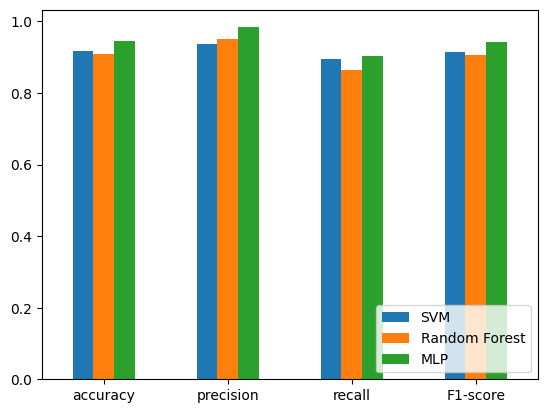

In [119]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

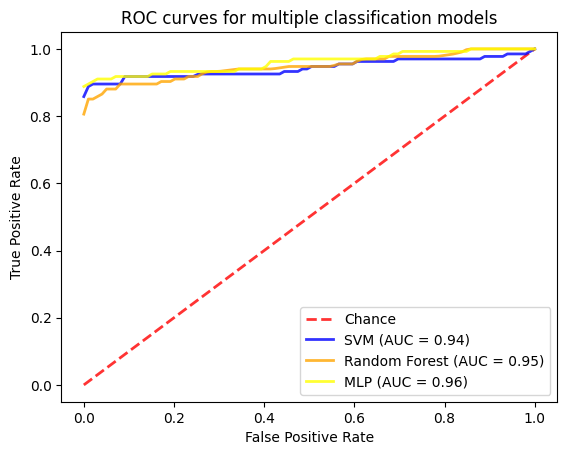

In [122]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='yellow', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that both classification models perform significantly better than a random guess (the red dashed `no skill` line). 

## Conclusion:

From the above plots,
- MLP fares slightly better compared to SVM and Random forest.
- Since none of the chosen models has bad score, we can't compare the plots for a bad model.
- ROC curve shows high positive rate across all thresholds compared to an ideal case.

